In [1]:
using Plots
using StatsBase
using DataFrames

using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile

# Strong Form

In [65]:
#N = 10; 
#h = 1/N;
#xstart = -0. 
#xend = 1.
#x = Vector(xstart:h:xend);
nelements = 100; nnodes = nelements+1; h = 1/nelements
x = Vector(0:h:1);

In [66]:
# define the so-called source function 
function strong_form(x)
    
    # Case 1
    #return x^4/12-x/12+1/2
    
    # Case 2
    #return x^4-2*x^3+(3/2)*x^2-x/2+1/16
    
    # Case 3
    return -(x^4)/24+(x^3)/12-x/24
    
end 

function moment_strong_form(x)
    # Case 1
    #return x^2
    
    # Case 2
    #return 12*(x^2)-12*x+3
    
    # Case 3
    return -(x^2)/2+x/2
    
end 

f = strong_form.(x);
M = moment_strong_form.(x)

101-element Vector{Float64}:
 0.0
 0.00495
 0.0098
 0.014549999999999999
 0.019200000000000002
 0.02375
 0.0282
 0.03255
 0.0368
 0.04095
 0.045
 0.04895
 0.0528
 ⋮
 0.048949999999999994
 0.044999999999999984
 0.040949999999999986
 0.0368
 0.03254999999999997
 0.028200000000000003
 0.023749999999999993
 0.019199999999999995
 0.014550000000000007
 0.009800000000000031
 0.00495000000000001
 0.0

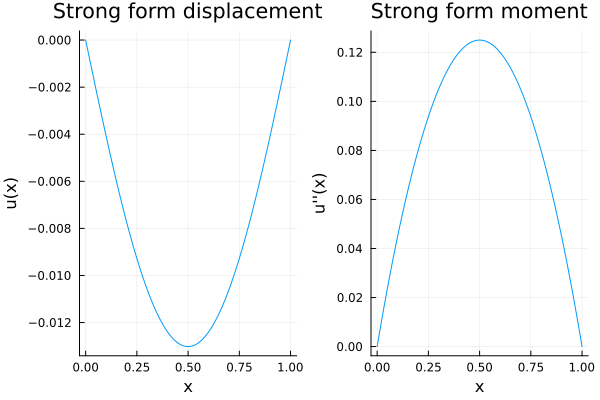

In [67]:
#plot(x,f)
#title!("Strong Form")
#xlabel!("x")
#ylabel!("U(x)")


#..plot the solution  
p1=plot(x,f,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Strong form displacement")

#..plot the solution  
p2=plot(x,M,legend=false)
xlabel!("x") 
ylabel!("u''(x)")
title!("Strong form moment")

plot(p1,p2,layout=(1,2))

# Weak form

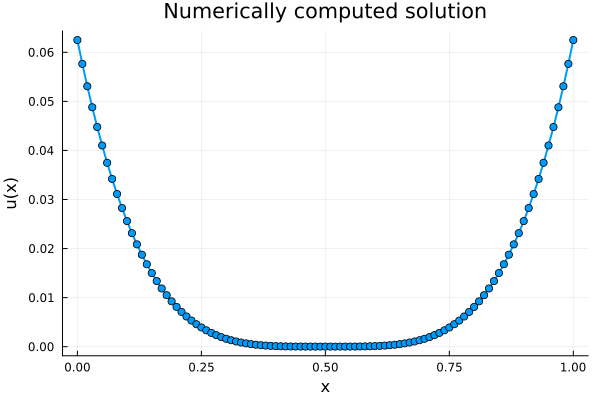

In [54]:
#..construct the mesh: see before 
nelements = 100; nnodes = nelements+1; h = 1/nelements
x = Vector(0:h:1)

function weak_form(x, nelements, nnodes)
    #..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:nelements) 
    edges = collect( [i, i+1] for i in 1:nelements) 
    
    #..Set the source 
    
    # Case 1
    #fsource(x) = x*x
    
    
    # Case 2
    fsource(x) = 12*(x-0.5)^2
    
    #..Initialize local and global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    A = zeros(Float64,nnodes, nnodes)
    f = zeros(Float64,nnodes)  
    
    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:nelements 
    
      xl, xr = points[i,:][1]
      floc = -(xr-xl)/2 * [fsource(xl), fsource(xr)]
      Aloc = (1/(xr-xl))*[1 -1; -1 1]
    
      for j=1:2 
        f[edges[i][j]] += floc[j]
        for k =1:2 
          A[edges[i][j], edges[i][k]] += Aloc[j,k]
        end 
      end 
    
    end
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    
    # Case 1
    #A[1,1] = 1;     A[1,2] = 0;        f[1]   = 1/2
    #A[end,end-1]=0; A[end,end] = 1;    f[end] = 1/2
    
    # Case 2
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 1/16
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 1/16
    
    #..solve the linear system
    u = A \ f
    return u
end


u = weak_form(x, nelements, nnodes)    
#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

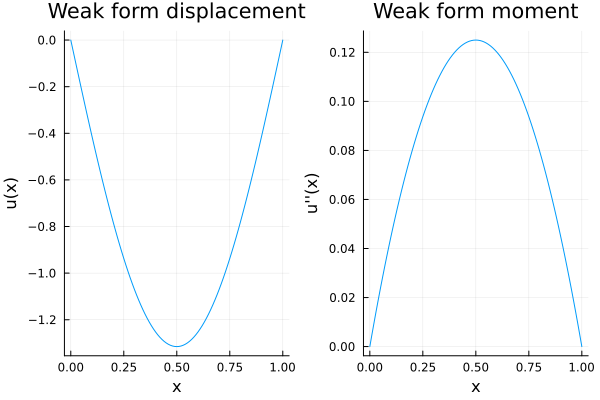

In [77]:
## Case 3

#..construct the mesh 
L = 1
nelements = 100; nnodes = nelements+1; h = L/nelements
x = Vector(0:h:L)

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:nelements) 
edges = collect( [i, i+1] for i in 1:nelements) 

#..Set the source function 
fsource(x) = 1 

#..Initialize local and global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,nnodes, nnodes)
f = zeros(Float64,nnodes)  

#..Perform loop over elements and assemble global matrix and vector 
for i=1:nelements 

  xl, xr = points[i,:][1]
  floc = (xr-xl)/2 * [fsource(xl), fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  for j=1:2 
    f[edges[i][j]] += floc[j]
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]
    end 
  end 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

#..construct linear system of double size 
I   = UniformScaling(nnodes)
nul = 0*I; 
B   = [-A -I*h; nul A]
ff  = [0*f; f]

#..solve the linear system
uu = B \ ff 

#..retrieve computed solution 
udisp = uu[1:nnodes]
umom  = uu[nnodes+1:end]

#..plot the solution  
p1=plot(x,udisp,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Weak form displacement")

#..plot the solution  
p2=plot(x,umom,legend=false)
xlabel!("x") 
ylabel!("u''(x)")
title!("Weak form moment")

plot(p1,p2,layout=(1,2))

# Convergence

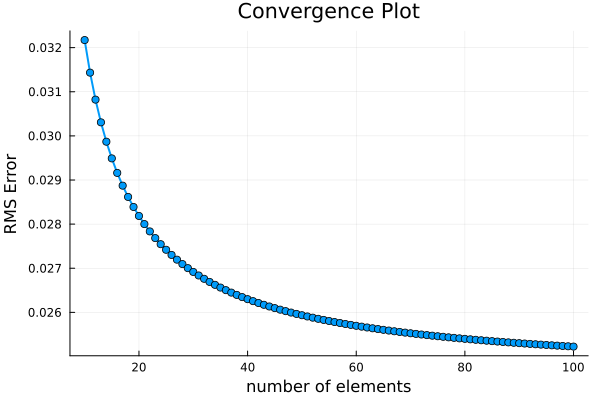

In [78]:
rmse_array = Vector{Float64}()
for nelements = 10:100
    h = 1/nelements;
    nnodes = nelements+1
    x = Vector(0:h:1);
    f = strong_form.(x);
    u = weak_form(x, nelements, nnodes);
    rmse = rmsd(u, f; normalize=false);
    append!(rmse_array, rmse);
end
x = Vector(10:100);
p3=plot(x,rmse_array,shape=:circle,lw=2,legend=false)
title!("Convergence Plot")
xlabel!("number of elements")
ylabel!("RMS Error")

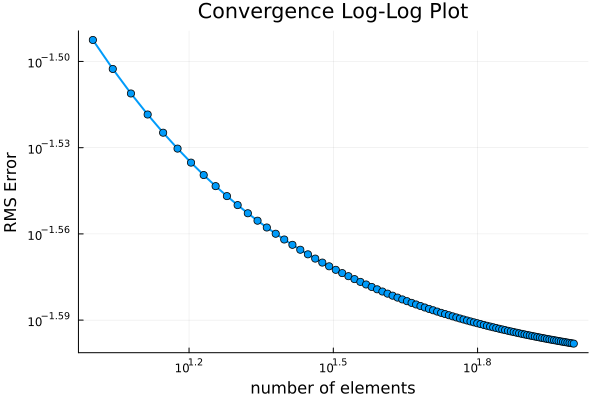

In [79]:
rmse_array = Vector{Float64}()
for nelements = 10:100
    h = 1/nelements;
    nnodes = nelements+1
    x = Vector(0:h:1);
    f = strong_form.(x);
    u = weak_form(x, nelements, nnodes);
    rmse = rmsd(u, f; normalize=false);
    append!(rmse_array, rmse);
end
x = Vector(10:100);
p3=plot(x,rmse_array,shape=:circle,lw=2,legend=false, xaxis=:log, yaxis=:log)
title!("Convergence Log-Log Plot")
xlabel!("number of elements")
ylabel!("RMS Error")

In [80]:
# Extract the slope from the coefficients
y2 = log.(rmse_array)[end]
y1 = log.(rmse_array)[1]
x2 = log.(x)[end]
x1 = log.(x)[1]
slope = (y2-y1)/(x2-x1)

# Display the slope
println("Slope: $slope")

Slope: -0.10563460124563086
